In [1]:
# Import modules and subroutines:

include("../subroutines/Subroutines.jl");

#using Profile
#using ProfileVega

In [2]:
# Load the chemical data into julia as an array of chemical data structs:
# (one struct obtained for each molecular geometry as set up in the config file)

cdata_list = ReadIn("../datasets/pyscf_data/h2o_sto-3g_080222%000756.hdf5");

chemical_data = cdata_list[1]

println("Molecule name: ", chemical_data.mol_name)
println("Basis set: ", chemical_data.basis)
println("Molecular geometry: ", chemical_data.geometry)
println("RHF energy: ", chemical_data.e_rhf)
println("FCI energy: ", chemical_data.e_fci)

Molecule name: h2o
Basis set: sto-3g
Molecular geometry: O 0.0 0.0 0.0; H 1.0 0.0 0.0; H 0.0 1.0 0.0; 
RHF energy: -74.96117113786774
FCI energy: -75.01927599660624


In [3]:
# Run a DMRG calculation:

sites = siteinds("Electron", chemical_data.N_spt, conserve_qns=true);

hf_ord = collect(1:chemical_data.N_spt)

opsum = GenOpSum(chemical_data, hf_ord, tol=1E-12)

H = MPO(opsum, sites, cutoff=1E-16, maxdim=10000);

sweeps = Sweeps(10) # number of sweeps is 5
maxdim!(sweeps,7) # gradually increase states kept
cutoff!(sweeps,1E-10) # desired truncation error
setnoise!(sweeps, 1e-6, 1e-7, 1e-8, 0.0)

psi, e_dmrg = RunDMRG(
    chemical_data, 
    sites, hf_ord, H, 
    sweeps, 
    spinpair=false, 
    spatial=true
)

println("DMRG energy: ", e_dmrg + chemical_data.e_nuc)

dens = expect(psi,"Ntot")
#println("Site densities: ", dens)
println("Expected particle number: ", chemical_data.N_el)
println("Particle number: ", sum(dens))

DMRG energy: -75.01525962634483
Expected particle number: 10
Particle number: 10.000000000000004


In [4]:
Ipq = MutualInformation(psi, chemical_data, dim=4);

display(Ipq)

7×7 Matrix{Float64}:
 0.0         1.0111e-5    2.12574e-6   1.82125e-6  …  1.2895e-6   4.49465e-6
 1.0111e-5   0.0          0.00825068   0.00993829     0.0110513   0.00877715
 2.12574e-6  0.00825068   0.0          0.031293       0.044915    0.0731371
 1.82125e-6  0.00993829   0.031293     0.0            0.0477355   0.031118
 8.19552e-7  0.000265266  0.000694435  0.00106614     0.00477821  0.000494142
 1.2895e-6   0.0110513    0.044915     0.0477355   …  0.0         0.0446672
 4.49465e-6  0.00877715   0.0731371    0.031118       0.0446672   0.0

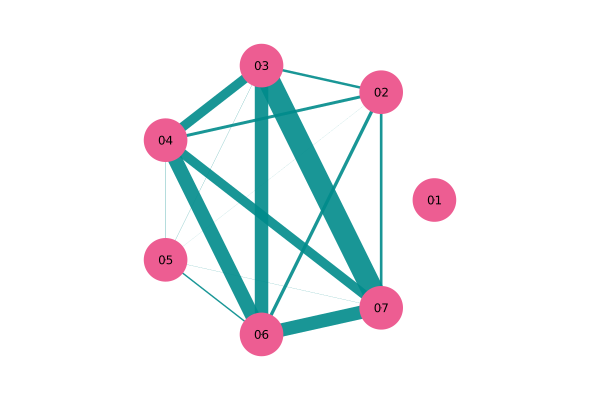

In [5]:
OrbitalGraphPlot(Ipq, multiplier=300)

In [6]:
ord = SimulatedAnnealing(Ipq, steps=1e4, tpow=5, swap_mult=3.0)

println(ord)

[1, 5, 7, 3, 6, 4, 2]


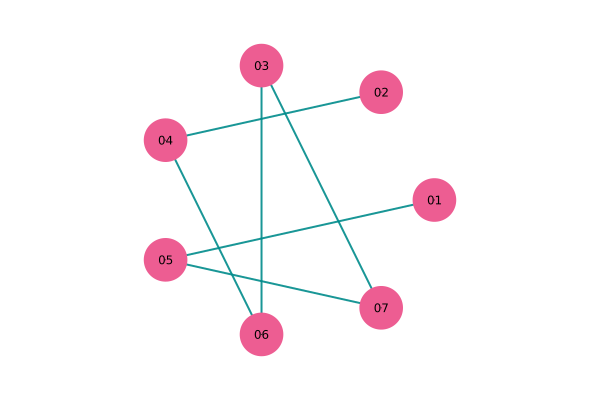

In [7]:
OrbitalGraphPlot(GraphMat(ord, directed=false), multiplier=2)

In [8]:
opsum = GenOpSum(chemical_data, ord, tol=1E-12)

H = MPO(opsum, sites, cutoff=1E-16, maxdim=10000);

sweeps = Sweeps(10) # number of sweeps is 5
maxdim!(sweeps,7) # gradually increase states kept
cutoff!(sweeps,1E-10) # desired truncation error
setnoise!(sweeps, 1e-6, 1e-7, 1e-8, 0.0)

psi, e_dmrg = RunDMRG(
    chemical_data, 
    sites, hf_ord, H, 
    sweeps, 
    spinpair=false, 
    spatial=true
)

println("DMRG energy: ", e_dmrg + chemical_data.e_nuc)

dens = expect(psi,"Ntot")
#println("Site densities: ", dens)
println("Expected particle number: ", chemical_data.N_el)
println("Particle number: ", sum(dens))

DMRG energy: -75.01885581812915
Expected particle number: 10
Particle number: 10.0


-0.20368852885610478
19


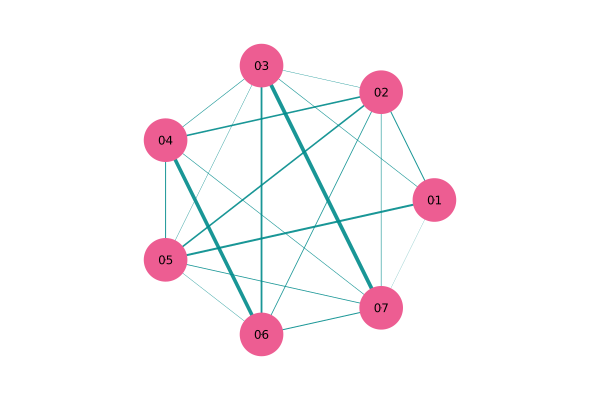

In [20]:
# Generate priority orderings:


ord_list = []

ord, inf = SimulatedAnnealing(Ipq, steps=1e6, swap_mult=3.0, tpow=5, return_inf=true)

println(inf)

push!(ord_list, ord)

# Just use the same geometry over:
#ord_list = vcat(ord_list, [ord for i=1:18])

# Use random geometries:
#ord_list = vcat(ord_list, [randperm(chemical_data.N_spt) for i=1:18])

# Use a selection of highest priority chains:
ord_list = vcat(ord_list, PriorityOrderings([6,5,5,6], Ipq))

# Use a modified distance measure over a set of geometries:
"""
ord_list = vcat(ord_list, SimulatedAnnealing(Ipq, M=36, cost_func="mixdist", gamma=0.9, steps=1e4, swap_mult=3.0, tpow=5))
"""

# "Greedy" annealer to find local minima (in edge-constrained search space)
"""
edges = PriorityChains(Ipq, 12, 1)
println(edges)
for edge in edges
    for i=1:5
        push!(ord_list, SimulatedAnnealing(Ipq, constrained_edges=[edge], steps=1e2, swap_mult=3.0, greedy=true))
    end
end
"""

println(length(ord_list))

graph_mat = zeros(chemical_data.N_spt,chemical_data.N_spt)

for ord in ord_list
    graph_mat += GraphMat(ord, directed=false)
end

OrbitalGraphPlot(graph_mat, multiplier=0.2)


In [21]:
# Get the H and S matrices:

global_maxdim = 3

sites = siteinds("Electron", chemical_data.N_spt, conserve_qns=true);

opt_sweeps = Sweeps(10) # number of sweeps is 5
maxdim!(opt_sweeps,global_maxdim) # gradually increase states kept
cutoff!(opt_sweeps,1E-10) # desired truncation error
setnoise!(opt_sweeps,1e-4,1e-6,1e-8,0.0)

noisy_sweeps = Sweeps(4) # number of sweeps is 5
maxdim!(noisy_sweeps,global_maxdim) # gradually increase states kept
cutoff!(noisy_sweeps,1E-10) # desired truncation error
setnoise!(noisy_sweeps,1e-2)

psi_opt, ham_opt = GenStates(
    chemical_data, 
    sites, 
    [ord_list[1]], 
    noisy_sweeps, 
    ovlp_opt=false,
    perm_tol=1E-10, 
    perm_maxdim=1000, 
    ham_tol=1E-8, 
    ham_maxdim=1000, 
    spinpair=false, 
    spatial=true, 
    singleham=false,
    verbose=true
)


psi_noisy, ham_noisy = GenStates(
    chemical_data, 
    sites, 
    ord_list[2:length(ord_list)], 
    noisy_sweeps, 
    ovlp_opt=false,
    weight=1e6,
    prior_states=psi_opt,
    prior_ords=[ord_list[1]],
    perm_tol=1E-10, 
    perm_maxdim=1000, 
    ham_tol=1E-10, 
    ham_maxdim=1000, 
    spinpair=false, 
    spatial=true, 
    singleham=false,
    verbose=true
)


psi_list = vcat(psi_opt, psi_noisy)
ham_list = vcat(ham_opt, ham_noisy)

H_mat, S_mat = GenSubspaceMats(
    chemical_data, 
    sites, 
    ord_list, 
    psi_list,
    ham_list,
    perm_tol=1E-10, 
    perm_maxdim=1000, 
    spinpair=false, 
    spatial=true, 
    singleham=false,
    verbose=true
);

Generating states:
Progress: [1/1] 
Done!
Generating states:
Progress: [18/18] 
Done!
computing matrix elements:
Progress: [190/190] 
Done!


In [22]:
##### Solve the generalized eigenvalue problem:

display(round.(S_mat,digits=3))

E, C, kappa = SolveGenEig(H_mat, S_mat, thresh="inversion", eps=1e-8)

e_gnd = minimum(filter(!isnan,real.(E)))+chemical_data.e_nuc
e_bsrf = minimum(diag(H_mat))+chemical_data.e_nuc

println("Minimum eigenvalue: ", minimum(filter(!isnan,real.(E))))
println("Condition number: ", kappa)

println("FCI energy: ", chemical_data.e_fci)
println("Final energy estimate: ", e_gnd)
println("Best single ref. estimate: ", e_bsrf)

println("Error: ", e_gnd - chemical_data.e_fci)
println("BSRfE: ", e_bsrf - chemical_data.e_fci)
println("Improvement: ", e_bsrf - e_gnd)
println("Percentage error reduction: ", (e_bsrf - e_gnd)/(e_bsrf - chemical_data.e_fci)*100)

19×19 Matrix{Float64}:
  1.0    -0.0    -0.992   0.993  -1.0    …   0.0  -0.993   0.993   0.0
 -0.0     1.0     0.0     0.0    -0.0        0.0   0.0     0.0     0.0
 -0.992   0.0     1.0    -0.995   0.992      0.0   0.993  -0.999   0.0
  0.993   0.0    -0.995   1.0    -0.993      0.0  -0.992   0.992   0.0
 -1.0    -0.0     0.992  -0.993   1.0        0.0   0.993  -0.993   0.0
  0.994  -0.0    -0.996   0.996  -0.994  …   0.0  -0.994   0.995  -0.0
 -0.994   0.0     0.993  -0.99    0.994     -0.0   0.994  -0.994   0.0
 -0.996   0.0     0.996  -0.996   0.996      0.0   0.996  -0.996   0.0
 -0.998   0.0     0.992  -0.993   0.998      0.0   0.994  -0.992   0.0
 -0.994  -0.0     0.996  -0.996   0.994      0.0   0.994  -0.995  -0.0
  0.998  -0.0    -0.992   0.993  -0.998  …   0.0  -0.994   0.993   0.0
  0.0     0.0     0.0    -0.0    -0.0        0.0   0.0     0.0     0.995
 -0.0    -0.0     0.0    -0.0     0.0       -0.0   0.0    -0.0     0.997
  0.0     0.0     0.0    -0.0    -0.0        0.0  

Minimum eigenvalue: -83.84959009529331
Condition number: 1.0197533381479315e7
FCI energy: -75.01927599660624
Final energy estimate: -75.00856992628239
Best single ref. estimate: -74.99728388618163
Error: 0.010706070323848849
BSRfE: 0.02199211042460547
Improvement: 0.011286040100756622
Percentage error reduction: 51.318585996773834


In [23]:
kappa_list = EigCondNums(E, C)
println(round.(kappa_list, digits=4))

[0.0119, 0.012, 0.012, 0.012, 0.012, 0.012, 0.012, 0.0121, 0.0121, 0.0121, 0.0121, 0.0121, 0.0122, 0.0122, 0.0122, 0.0122, 0.0122, 0.0122, 0.0123]


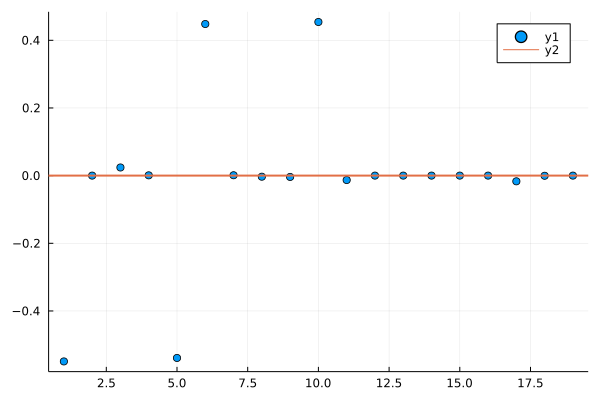

In [24]:
scatter(collect(1:length(C[:,1])), real.(C[:,1]),lw=2)
hline!([0.0], lw=2)

In [ ]:
re_psi_list = NLOptimizeStates(
    chemical_data,
    psi_list,
    ham_list,
    ord_list;
    tol=1e-12,
    maxdim=global_maxdim,
    perm_tol=1e-12,
    perm_maxdim=5000,
    loops=2,
    sweeps=1,
    thresh="projection",
    eps=1e-8,
    verbose=true
);

Starting energy: -83.84959032311313
Run 1 of 2:

Optimizing state 1 of 19:
Sweep 1 of 1: 
Progress: [6/6]
Sweep 1 complete!
Ground state energy: -83.8519144780745
Condition number: 9.310012936998362e6
Done!
Optimizing state 2 of 19:
Sweep 1 of 1: 
Progress: [6/6]
Sweep 1 complete!
Ground state energy: -83.85191447807816
Condition number: 9.31001293829606e6
Done!
Optimizing state 3 of 19:
Sweep 1 of 1: 
Progress: [6/6]
Sweep 1 complete!
Ground state energy: -83.85303794277212
Condition number: 8.751069922465967e6
Done!
Optimizing state 4 of 19:
Sweep 1 of 1: 
Progress: [6/6]
Sweep 1 complete!
Ground state energy: -83.85327342974861
Condition number: 8.356506182427873e6
Done!
Optimizing state 5 of 19:
Sweep 1 of 1: 
Progress: [6/6]
Sweep 1 complete!
Ground state energy: -83.85349242938635
Condition number: 7.77436733701818e6
Done!
Optimizing state 6 of 19:
Sweep 1 of 1: 
Progress: [6/6]
Sweep 1 complete!
Ground state energy: -83.85356339385865
Condition number: 6719.431381341268
Done!
Op

┌ Warning: Optimization interrupted, recovering intermediate results...
└ @ BlackBoxOptim /home/oskar/.julia/packages/BlackBoxOptim/dvDGl/src/opt_controller.jl:483


computing matrix elements:
Progress: [190/190] 
Done!


19×19 Matrix{Float64}:
  1.0           0.0           0.216431     …  -0.190724     -0.170508
  0.0           1.0           0.0             -1.69804e-47  -3.91582e-19
  0.216431      0.0           1.0              0.387624      0.413881
  0.101844      0.0          -0.395359        -0.595228     -0.585168
 -0.255525      3.38198e-18  -0.359909         0.169106      0.178137
 -6.79152e-19  -0.0674865     8.70028e-35  …   5.63247e-18   0.0
  0.0658961     7.27815e-19  -0.312573        -0.77599      -0.746956
 -0.150468      1.22979e-18   0.210375        -0.171383     -0.175315
  0.195978      4.64291e-20  -0.267641        -0.00977412   -0.00492153
  1.65866e-19   0.0           0.0             -7.5229e-17   -1.12994e-35
 -0.178828      0.0           0.444585     …   0.99247       0.993798
  0.206821     -7.78736e-18   0.32162          0.134128      0.13504
  0.180646      0.0          -0.423109        -0.992525     -0.993081
 -5.26298e-18  -0.000432988   9.24717e-17     -4.13168e-30  -0.0


Minimum eigenvalue: -83.85452428924364
Condition number: 7542.968429390427
FCI energy: -75.01927599660624
Final energy estimate: -75.01350412023272
Best single ref. estimate: -74.99478208198019
Error: 0.005771876373515283
BSRfE: 0.024493914626049218
Improvement: 0.018722038252533935
Percentage error reduction: 76.43546790443652
[0.0315, 0.9856, 2.8505, 0.0121, 1.4523, 0.9935, 1.5438, 7.5652, 1.0617, 2.5382, 3.6041, 0.0122, 1.924, 1.8591, 0.2203, 0.1782, 0.0143, 0.0152, 0.0157]


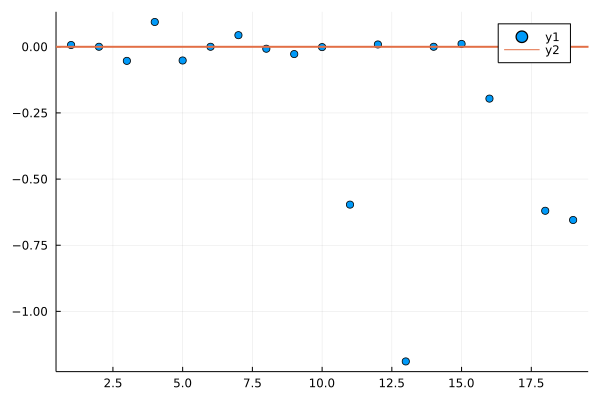

In [15]:
H_mat, S_mat = GenSubspaceMats(
    chemical_data, 
    sites, 
    ord_list, 
    re_psi_list,
    ham_list,
    perm_tol=1E-10, 
    perm_maxdim=1000, 
    spinpair=false, 
    spatial=true, 
    singleham=false,
    verbose=true
);

##### Solve the generalized eigenvalue problem:

display(S_mat)

E, C, kappa = SolveGenEig(H_mat, S_mat, thresh="none", eps=1e-9)

e_gnd = minimum(filter(!isnan,real.(E)))+chemical_data.e_nuc
e_bsrf = minimum(diag(H_mat))+chemical_data.e_nuc

println("Minimum eigenvalue: ", minimum(filter(!isnan,real.(E))))
println("Condition number: ", kappa)

println("FCI energy: ", chemical_data.e_fci)
println("Final energy estimate: ", e_gnd)
println("Best single ref. estimate: ", e_bsrf)

println("Error: ", e_gnd - chemical_data.e_fci)
println("BSRfE: ", e_bsrf - chemical_data.e_fci)
println("Improvement: ", e_bsrf - e_gnd)
println("Percentage error reduction: ", (e_bsrf - e_gnd)/(e_bsrf - chemical_data.e_fci)*100)

kappa_list = EigCondNums(E, C)
println(round.(kappa_list, digits=4))

scatter(collect(1:length(C[:,1])), real.(C[:,1]),lw=2)
hline!([0.0], lw=2)


In [16]:
e_corr = chemical_data.e_fci-chemical_data.e_rhf

e_corr_dmrg = e_bsrf - chemical_data.e_rhf

e_corr_tnqe = e_gnd - chemical_data.e_rhf

pctg_dmrg = e_corr_dmrg/e_corr*100

pctg_tnqe = e_corr_tnqe/e_corr*100

println("Percent correlation energy with single-geometry DMRG: $pctg_dmrg")
println("Percent correlation energy with multi-geometry TNQE: $pctg_tnqe")

Percent correlation energy with single-geometry DMRG: 57.845324542853525
Percent correlation energy with multi-geometry TNQE: 90.0664479721201
